# K-means clustering -- isotropic data clusters, works ok!

Here we're going to apply K-means clustering to various datasets. First with an algorithm written by hand, then using scikit-learn.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_blobs
import Kmeans_utils as utils
from sklearn.cluster import KMeans

%matplotlib inline

### Get data

Here we randomly generate some data using make_blobs() from scikit-learn. make_blobs() generates isotropic gaussian blobs and we know which data point belongs to which blob. We'll use K-means clustering to try to correctly predict the cluster assignments of each datapoint. 

In [2]:
num_samples = 500
num_features = 2  # 2D data, so we can visualise easily
num_clusters = 4  # number of centres

data, labels = make_blobs(num_samples, num_features, num_clusters, random_state=6) #6
data = utils.normalise_data(data)

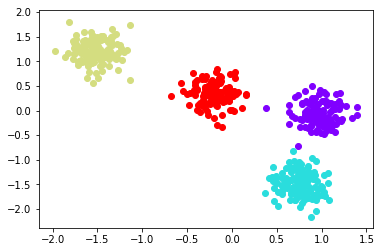

In [3]:
#Visualise the data
colors = cm.rainbow(np.linspace(0, 1, num_clusters))  # colours for plotting
for i in range(num_clusters):
    plt.scatter(data[labels == i, 0], data[labels == i, 1], color=colors[i])

### Initialise cluster centroids

In [4]:
# initialise cluster centres and error values
np.random.seed(0)  # set seed
init_cluster_position = utils.initialise_centres(num_clusters, data)
[error, prev_error] = [0, 1]  # use some random values
cluster_positions = init_cluster_position

### Perform the K-means clustering algorithm

In [5]:
# The K-means algorithm
while not np.isclose(error, prev_error, rtol = 1e-10):
    
    # update error 
    prev_error = error

    # expectation step
    idx_closest_cluster, error = utils.get_expectation(data, cluster_positions)

    # maximisation step
    cluster_positions = utils.find_centers(data, idx_closest_cluster, num_clusters)

### Plot the data

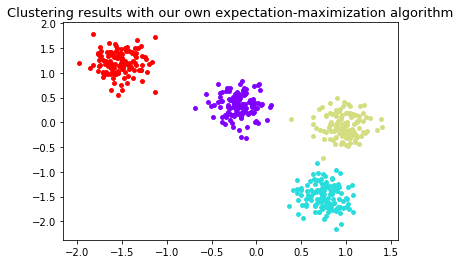

In [11]:
# show final cluster assignments
for j in range(num_clusters):
    plt.scatter(data[j == idx_closest_cluster, 0], data[j == idx_closest_cluster, 1], color=colors[j], s=15)
_ = plt.title('Clustering results with our own expectation-maximization algorithm', fontsize=13)

It looks like we did a pretty good job! Almost all data points are clustered correctly. What happens, however, if we initialise our cluster centroids in a different way? Below we repeat the process above, now with four different random initialisations. 

### Influence of initial centroid assignment

What happens if we try out different centroid initialisations?

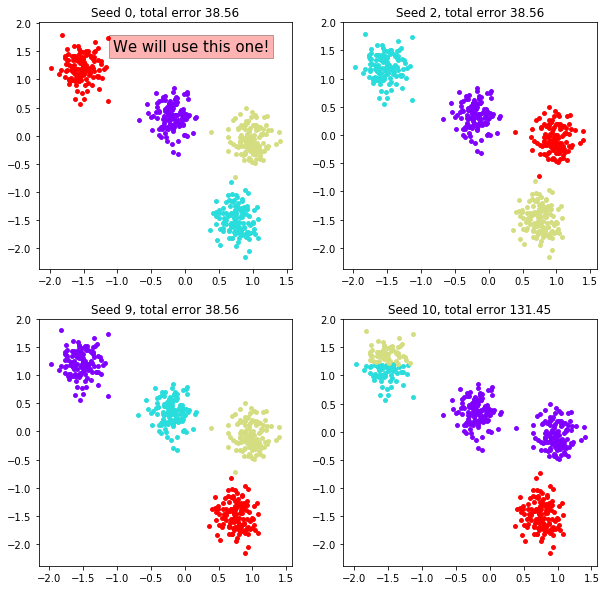

In [13]:
# initialise cluster centres and error values
fig, axs = plt.subplots(2,2, figsize = (10, 10)); axs = axs.ravel()

seeds = [0, 2, 9, 10]
errors = np.zeros(len(seeds))

for i, seed in enumerate(seeds):
    # initialise
    np.random.seed(seed)
    cluster_position = utils.initialise_centres(num_clusters, data)
    [error, prev_error] = [0, 1]

    # the K-means algorithm
    while not np.isclose(error, prev_error, rtol = 1e-10):
        prev_error = error
        idx_closest_cluster, error = utils.get_expectation(data, cluster_position)
        cluster_position = utils.find_centers(data, idx_closest_cluster, num_clusters)
    errors[i] = error
    
    # show final cluster assignments
    for j in range(num_clusters):
        axs[i].scatter(data[j == idx_closest_cluster, 0], data[j == idx_closest_cluster, 1],
                       color=colors[j], s=15)
    axs[i].set_title('Seed {}, total error {:.2f}'.format(seed, error))

_ = axs[np.argmin(errors)].text(0.6,0.9, 'We will use this one!', 
                               horizontalalignment = 'center',
                               verticalalignment = 'center',
                               transform=axs[np.argmin(errors)].transAxes,
                               fontsize = 15, bbox=dict(facecolor='red', alpha=0.3))

We see that some centroid initialisations lead to bad clustering (the lower right graph). That's why it can be important to run the clustering algorithm several times and pick the one with the lowest final error (defined as the sum of distances from each point to its closest cluster centroid). In this case, this leads to the classification shown in the upper left figure (the all results except for the lower right one are equally good).

# Using scikit-learn

Now we'll use the K-means clustering algorithm of scikit-learn. It gives a very similar answer to our own algorithm. The default cluster centroid initialization of sklearn uses a smart way to speed up convergence.

In [14]:
kmeans = KMeans(n_clusters=num_clusters)

In [15]:
kmeans.fit(data)
labels = kmeans.fit_predict(data)

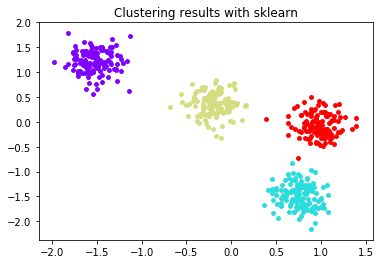

In [16]:
for j in range(num_clusters):
    plt.scatter(data[labels == j, 0], data[labels == j, 1], color=colors[j], s=15)
_ = plt.title('Clustering results with sklearn')

# Voronoi cells

All the K-means algorithm is doing, is finding an optimal set of cluster centroids and assigning each datapoint to its closest cluster centroid. This algorithm will create a Voronoi diagram, which itself is a partitioning of a plane into regions based on distance to points in a specific subset of the plane. In a voronoi diagram a set of points (centroids) is specified and for each point there is a corresponding region consisting of all points closer to that seed than to any other. This is exactly what K-means is doing! 

We can show this by simply telling K-means to partition points randomly spread over the plane

In [17]:
random_data = np.random.rand(10000,2)  # random (x,y) points, in [[0,1], [0,1]]

In [18]:
num_clusters = 20

#Fit k-means
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(random_data)
labels = kmeans.fit_predict(random_data)

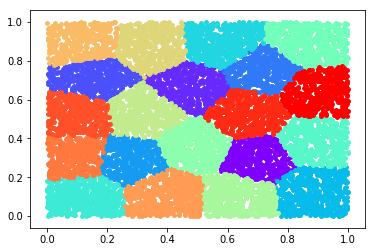

In [19]:
colors = cm.rainbow(np.linspace(0, 1, num_clusters)) #colours for plotting
for j in range(num_clusters):
    plt.scatter(random_data[labels == j, 0], random_data[labels == j, 1], color=colors[j], s=15)

The K-means algorithm does not assume any covariance to be present in the data clusters, which is why it does not work well in cases where such a covariance _is_ present. This is shown in the **'Anisotropic_clusters_Kmeans_GMM' notebook!**